In [198]:
from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
from PIL import Image
import torch
import pandas as pd
import re
import gc
from tqdm import tqdm
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import ast
#import nbimporter
#from making_color_images import segment_outline

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [ ]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
data_folder = WORK / "color-concept-entanglement" / "data"

fruit = data_folder / "fruit"
color_outlines = data_folder / "color_images"

/mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images


# Load Model

In [3]:
# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [137]:
def clean_instruction_tokens(text):
    cleaned_text = re.sub(r'\[INST\]\s*\n?.*?\[/INST\]\s*', '', text, flags=re.DOTALL)
    return cleaned_text.strip()


def mllm_testing(df, processor, model, most="True"):
    with torch.inference_mode():
        torch.cuda.empty_cache()
        gc.collect()
        generated_texts = []
        for idx, row in df.iterrows():
            instruction_tokens = "[INST] <image>\n"
            end_tokens = "[/INST]"

            object_name = row['object']
            #question = f"What color is {'a' if most == 'True' else 'this'} {object_name}?"
            if most == "True":
                object_name_plural = object_name if object_name.endswith("s") else object_name + "s"
                question = f"What color are most {object_name_plural}?"

            else:
                question = f"What color is this {object_name}?"

            prompt = f"{instruction_tokens} Answer with one word. {question} {end_tokens}"

            try:
                image = Image.open(row['image_path']).convert("RGB")
                image = image.resize((256, 256), Image.LANCZOS)
            except FileNotFoundError:
                print(f"Warning: Image not found for {row['object']}")
                generated_texts.append(None)
                continue  # Skip to the next row in the DataFrame

            inputs = processor(images=image, text=prompt, return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}
            # Perform a forward pass with the model
            outputs = model.generate(**inputs, max_new_tokens=10, num_beams=1, do_sample=False, temperature=1.0, pad_token_id=processor.tokenizer.eos_token_id)  # Adjust max_new_tokens as needed
            predicted_answer = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
            predicted_answer = clean_instruction_tokens(predicted_answer)

            generated_texts.append(predicted_answer)
            #print(torch.cuda.memory_summary())

            to_delete = ['inputs', 'outputs', 'image_inputs', 'video_inputs', 'generated_ids', 'prepare_inputs', 'image', 'pil_images', 'inputs_embeds']
            for var_name in to_delete:
                if var_name in locals():
                    var = locals()[var_name]
                    if isinstance(var, dict):
                        for v in var.values():
                            if torch.is_tensor(v) and v.is_cuda:
                                del v
                    elif torch.is_tensor(var) and var.is_cuda:
                        del var
                    del locals()[var_name]
            if hasattr(model, 'clear_kv_cache'):
                model.clear_kv_cache()
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

            #print(torch.cuda.memory_summary())
        
        pred_color = [c.lower() for c in generated_texts]
        pred_color = ["grey" if c == "gray" else c for c in pred_color]
        df['predicted_color'] = pred_color

        if 'inputs' in locals(): del inputs
        if 'image' in locals(): del image
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()
    return df

# Simple Fruit Dataset

In [120]:
# Simple fruit dataset
evaluate_fruit = True
df = pd.read_parquet(fruit/ "fruit_images.parquet")

if evaluate_fruit:
    batch_size = 1
    results = []

    for i in tqdm(range(0, len(df), batch_size), desc="Running predictions"):
        batch_df = df.iloc[i:i + batch_size].copy()
        with torch.inference_mode():

            df_most = mllm_testing(batch_df, processor, model, most="True")
            df_most = df_most.rename(columns={"predicted_color": "pred_color_most"})

            df_this = mllm_testing(batch_df, processor, model, most="False")
            df_this = df_this.rename(columns={"predicted_color": "pred_color_this"})

            result_df = pd.merge(df_most, df_this, on=["image_path", "object", "image_type"])

        results.append(result_df)
        del result_df
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

    df = pd.concat(results, ignore_index=True)
    display(df)

    out_path = fruit / "outline_results.csv"
    df.to_csv(out_path, index=False)
elif (fruit / "outline_results.csv").exists():
    fruit_df = pd.read_csv(fruit / "outline_results.csv")
    display(fruit_df)

Running predictions: 100%|██████████| 30/30 [04:09<00:00,  8.32s/it]


object  image_type                             image_path  \
0       banana   grayscale                data/fruit/banana1.jpeg   
1       banana  background     data/fruit/banana1_background.jpeg   
2       banana       color          data/fruit/banana1_color.jpeg   
3       banana   grayscale                data/fruit/banana2.jpeg   
4       banana  background     data/fruit/banana2_background.jpeg   
5       banana       color          data/fruit/banana2_color.jpeg   
6    blueberry   grayscale              data/fruit/blueberry.jpeg   
7    blueberry  background   data/fruit/blueberry_background.jpeg   
8    blueberry       color        data/fruit/blueberry_color.jpeg   
9     cucumber   grayscale               data/fruit/cucumber.jpeg   
10    cucumber  background    data/fruit/cucumber_background.jpeg   
11    cucumber       color         data/fruit/cucumber_color.jpeg   
12       lemon   grayscale                 data/fruit/lemon1.jpeg   
13       lemon  background      data/fruit/lemon1_background.jpeg   
14       lemon       color           data/fruit/lemon1_color.jpeg   
15       lemon   grayscale                 data/fruit/lemon2.jpeg   
16       lemon  background      data/fruit/lemon2_background.jpeg   
17       lemon       color           data/fruit/lemon2_color.jpeg   
18      orange   grayscale                data/fruit/orange1.jpeg   
19      orange  background     data/fruit/orange1_background.jpeg   
20      orange       color          data/fruit/orange1_color.jpeg   
21      orange   grayscale                data/fruit/orange2.jpeg   
22      orange  background     data/fruit/orange2_background.jpeg   
23      orange       color          data/fruit/orange2_color.jpeg   
24  strawberry   grayscale             data/fruit/strawberry.jpeg   
25  strawberry  background  data/fruit/strawberry_background.jpeg   
26  strawberry       color       data/fruit/strawberry_color.jpeg   
27      tomato   grayscale                 data/fruit/tomato.jpeg   
28      tomato  background      data/fruit/tomato_background.jpeg   
29      tomato       color           data/fruit/tomato_color.jpeg   

   pred_color_most pred_color_this  
0           yellow          yellow  
1           yellow           white  
2           yellow          yellow  
3           yellow           black  
4           yellow           white  
5           yellow          yellow  
6            white           white  
7            white           white  
8             blue            blue  
9            green           white  
10           green           white  
11           green           green  
12          yellow           white  
13          yellow           white  
14          yellow          yellow  
15          yellow           white  
16          yellow           white  
17          yellow          yellow  
18          orange           white  
19          orange           white  
20          orange          orange  
21          orange           white  
22          orange           white  
23          orange          orange  
24             red           white  
25             red           white  
26             red             red  
27             red             red  
28             red           white  
29             red             red

# Outline Image Dataset 

In [175]:
df = pd.read_csv(data_folder / "colored_images.csv")
display(df)

correct_answer incorrect_answer              object  \
0     ['grey', 'black']              red  Norwegian elkhound   
1    ['black', 'brown']             pink        Newfoundland   
2               ['red']           yellow             lobster   
3     ['grey', 'black']            brown           car wheel   
4             ['green']              red            bullfrog   
..                  ...              ...                 ...   
350  ['brown', 'green']             blue         beer bottle   
351           ['green']           purple            parakeet   
352           ['green']             blue          lawn_mower   
353          ['yellow']           purple               lemon   
354           ['green']             blue             avocado   

                                             image_url  \
0    https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...   
1    https://fydn.imgix.net/m%2Fgen%2Fart-print-std...   
2    https://media.istockphoto.com/id/848729864/vec...   
3    https://www.shutterstock.com/image-illustratio...   
4    https://media.istockphoto.com/id/964986066/vec...   
..                                                 ...   
350  https://c8.alamy.com/comp/2XF01E0/hand-drawn-b...   
351  https://cdn.vectorstock.com/i/1000v/43/67/blac...   
352  https://i.etsystatic.com/35917727/r/il/6615c3/...   
353  https://i.pinimg.com/474x/14/b7/8c/14b78c7fe1c...   
354  https://previews.123rf.com/images/nixumbra1/ni...   

                                            image_path  \
0    /mnt/lustre/work/eickhoff/esx061/color-concept...   
1    /mnt/lustre/work/eickhoff/esx061/color-concept...   
2    /mnt/lustre/work/eickhoff/esx061/color-concept...   
3    /mnt/lustre/work/eickhoff/esx061/color-concept...   
4    /mnt/lustre/work/eickhoff/esx061/color-concept...   
..                                                 ...   
350  /mnt/lustre/work/eickhoff/esx061/color-concept...   
351  /mnt/lustre/work/eickhoff/esx061/color-concept...   
352  /mnt/lustre/work/eickhoff/esx061/color-concept...   
353  /mnt/lustre/work/eickhoff/esx061/color-concept...   
354  /mnt/lustre/work/eickhoff/esx061/color-concept...   

                                          gpt_response  score  watermark  \
0    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
1    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
2    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
3    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
4    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
..                                                 ...    ...        ...   
350  {'white_background': 'yes', 'style': 'illustra...   23.0       True   
351  {'white_background': 'yes', 'style': 'illustra...   23.0       True   
352  {'white_background': 'yes', 'style': 'illustra...   23.0       True   
353  {'white_background': 'yes', 'style': 'illustra...   23.0       True   
354  {'white_background': 'yes', 'style': 'illustra...   22.0       True   

     num_objects                                       cv_mask_path  \
0            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
1            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
2            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
3            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
4            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
..           ...                                                ...   
350          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
351          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
352          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
353          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
354          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   

                                         sam_mask_path  
0    /mnt/lustre/work/e

In [178]:
# Select specific objects for testing
df = df[df["object"].isin(["bullfrog", "pig", "king crab", "tick", "Norwegian elkhound", "beets"])]

In [179]:
df

correct_answer incorrect_answer              object  \
0     ['grey', 'black']              red  Norwegian elkhound   
4             ['green']              red            bullfrog   
49   ['brown', 'black']           purple                tick   
137   ['red', 'purple']           yellow               beets   
316   ['red', 'orange']            green           king crab   
327            ['pink']             blue                 pig   

                                             image_url  \
0    https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...   
4    https://media.istockphoto.com/id/964986066/vec...   
49   https://thumbs.dreamstime.com/b/illustration-w...   
137  https://media.istockphoto.com/id/1210415424/ve...   
316  https://thumbs.dreamstime.com/b/red-king-crab-...   
327  https://i.pinimg.com/474x/0b/86/5f/0b865f7fce6...   

                                            image_path  \
0    /mnt/lustre/work/eickhoff/esx061/color-concept...   
4    /mnt/lustre/work/eickhoff/esx061/color-concept...   
49   /mnt/lustre/work/eickhoff/esx061/color-concept...   
137  /mnt/lustre/work/eickhoff/esx061/color-concept...   
316  /mnt/lustre/work/eickhoff/esx061/color-concept...   
327  /mnt/lustre/work/eickhoff/esx061/color-concept...   

                                          gpt_response  score  watermark  \
0    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
4    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
49   {'white_background': 'yes', 'style': 'illustra...   45.0      False   
137  {'white_background': 'yes', 'style': 'illustra...   44.0      False   
316  {'white_background': 'yes', 'style': 'illustra...   27.0       True   
327  {'white_background': 'yes', 'style': 'illustra...   25.0       True   

     num_objects                                       cv_mask_path  \
0            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
4            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
49           1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
137          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
316          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
327          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   

                                         sam_mask_path  
0    /mnt/lustre/work/eickhoff/esx061/color-concept...  
4    /mnt/lustre/work/eickhoff/esx061/color-concept...  
49   /mnt/lustre/work/eickhoff/esx061/color-concept...  
137  /mnt/lustre/work/eickhoff/esx061/color-concept...  
316  /mnt/lustre/work/eickhoff/esx061/color-concept...  
327  /mnt/lustre/work/eickhoff/esx061/color-concept...

In [181]:
def normalize_colors(c):
    """Return a list of color strings from string or list-like entries."""
    if c is None:
        return []
    if isinstance(c, str):
        return [c.strip().lower()]
    try:
        return [str(x).strip().lower() for x in c if str(x).strip()]
    except Exception:
        return [str(c).strip().lower()]

def _variant_sort_key(p: Path):
    name = p.name
    m_fg = re.match(r"FG_(\d{3})\.png$", name)
    if m_fg:
        return (0, int(m_fg.group(1)))
    m_bg = re.match(r"BG_(\d{3})\.png$", name)
    if m_bg:
        return (1, int(m_bg.group(1)))
    return (9, name)

def collect_variants_for(image_path: str, target_color: str, out_root: Path = color_outlines):
    stem = Path(image_path).stem
    color_dir = out_root / f"{stem}_{target_color}"

    if not color_dir.exists():
        return []

    fg = list(color_dir.glob("FG_*.png"))
    bg = list(color_dir.glob("BG_*.png"))

    paths = fg + bg
    return sorted(paths, key=_variant_sort_key)

def show_variants_grid(image_path: str, target_color: str, out_root: Path = color_outlines, thumb_w: int = 256):
    """
    Display a 2-row grid:
      Row 1: FG 0..100% (11 images)
      Row 2: BG 10..100% (10 images), shifted right by 1 so both rows end in the same column.
    """
    paths = collect_variants_for(image_path, target_color, out_root)
    if not paths:
        print(f"No variants found for {image_path}")
        return

    # Split into 11 + 10 (by filename pattern)
    fg_paths = [p for p in paths if "FG_" in p.name]   # 11
    bg_paths = [p for p in paths if "BG_" in p.name]   # 10

    cols = len(fg_paths)
    rows = 2
    fig_w = cols * (thumb_w / 100)  # ~100 px ≈ 1 inch
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, rows * 2.8))

    # Normalize axes to 2 x cols
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[axes[0]], [axes[1]]]

    def _draw_row(ax_row, paths_row, title_prefix, start_col=0):
      for c in range(cols):
          ax = ax_row[c]
          ax.axis("off")
          idx = c - start_col
          if 0 <= idx < len(paths_row):
              p = paths_row[idx]
              im = Image.open(p).convert("RGB")
              ax.imshow(im)
              m = re.search(r"(\d{3})(?=\.png$)", p.name)
              pct = int(m.group(1)) if m else ""
              ax.set_title(f"{title_prefix} {pct}%", fontsize=fontsize)

    _draw_row(axes[0], fg_paths, "FG", start_col=0)  # 11 images
    _draw_row(axes[1], bg_paths, "BG", start_col=1)  # shift BG right by 1 (first slot empty)

    fig.suptitle(f"{Path(image_path).name} - {target_color}", fontsize=fontsize)
    plt.tight_layout()
    plt.show()

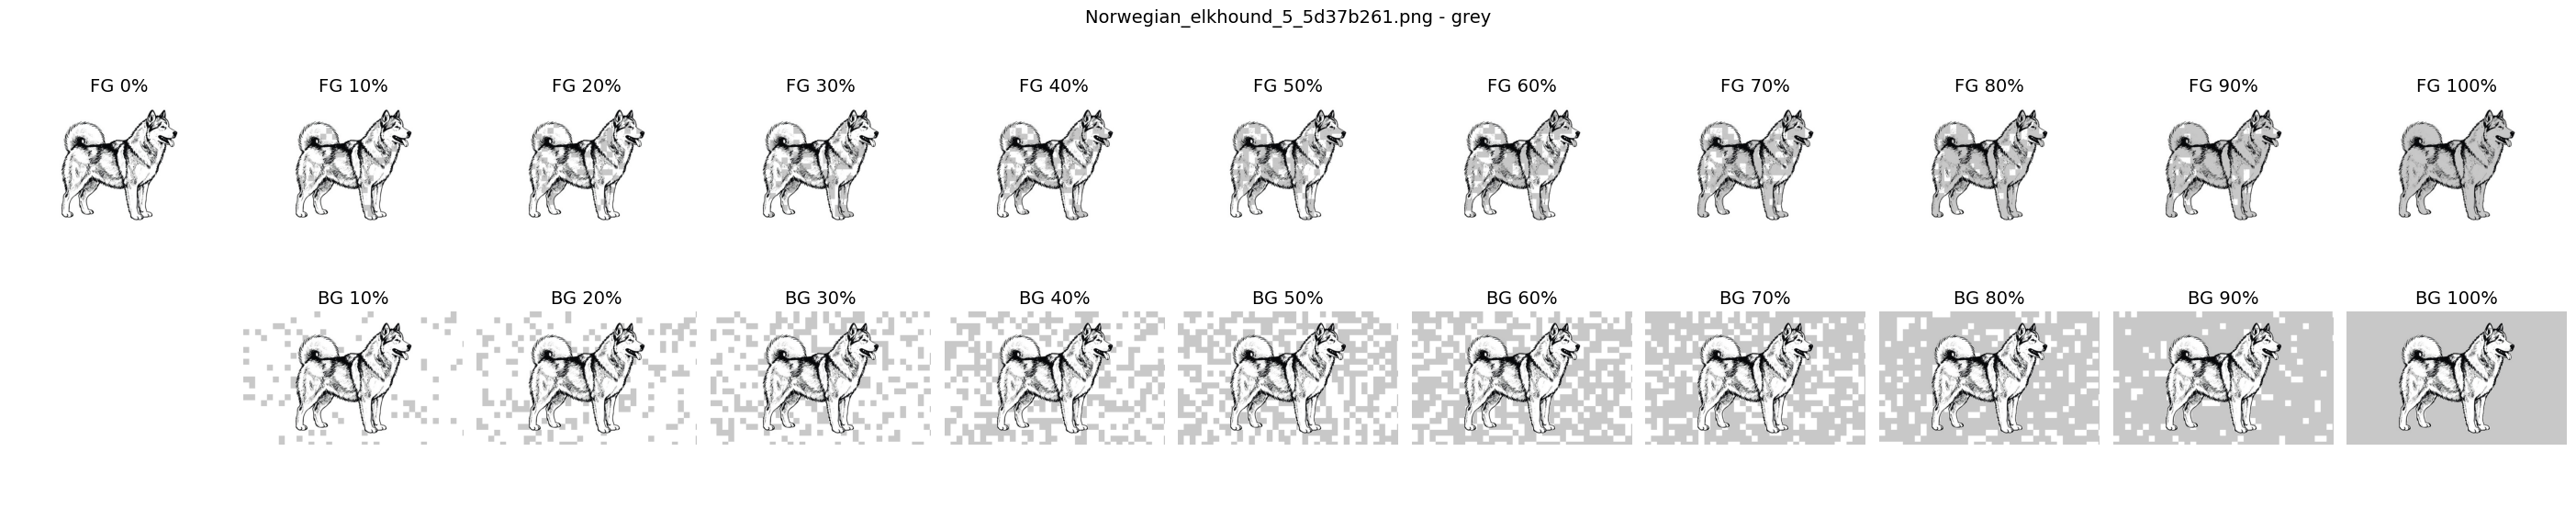

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Norwegian_elkhound_5_5d37b261.png


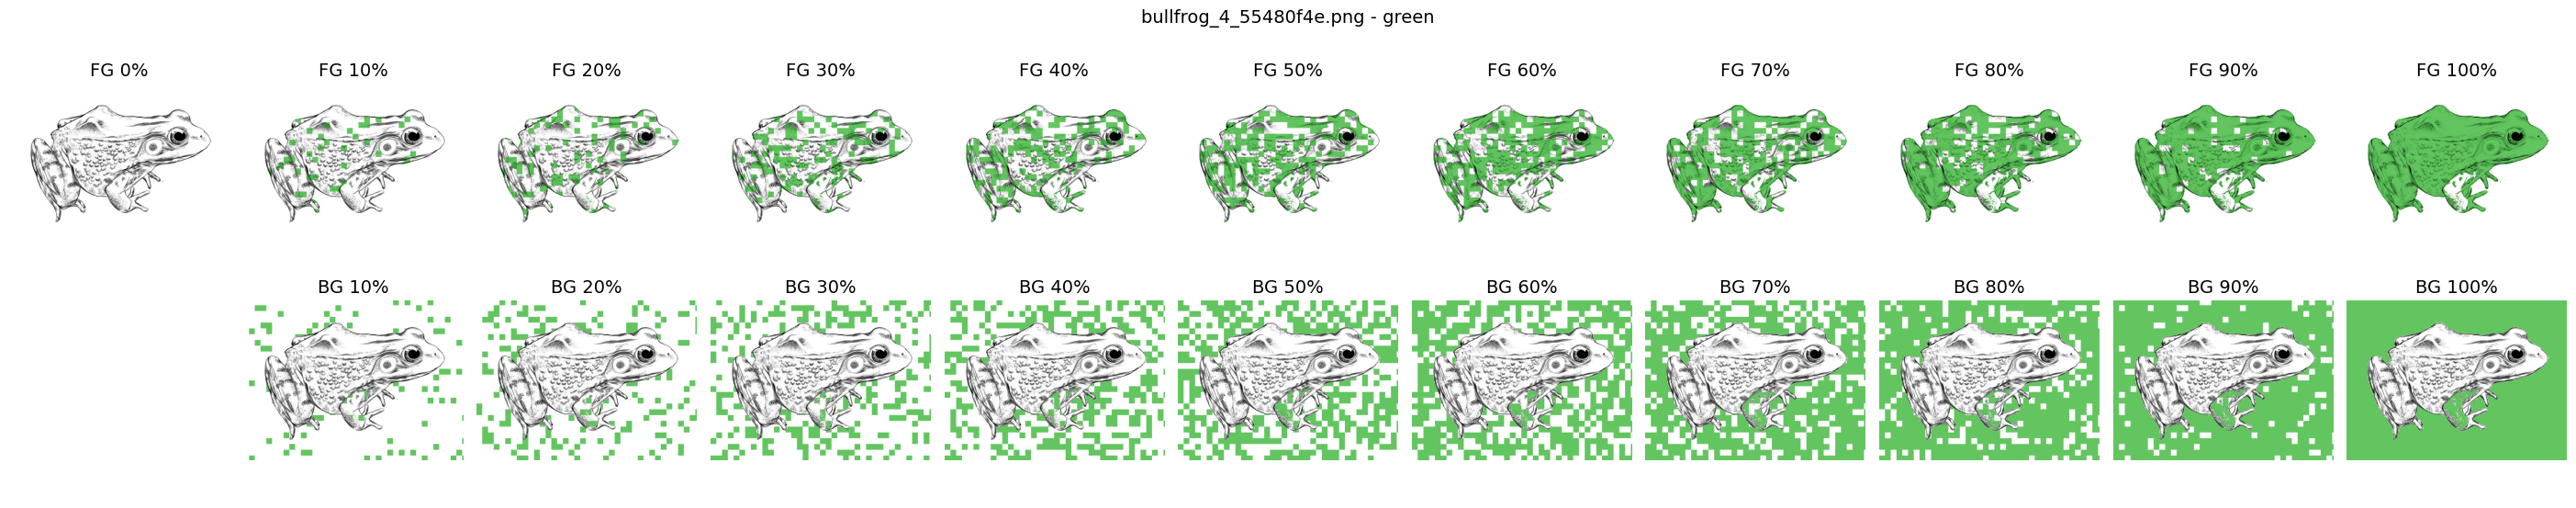

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/tick_1_6846a63c.png


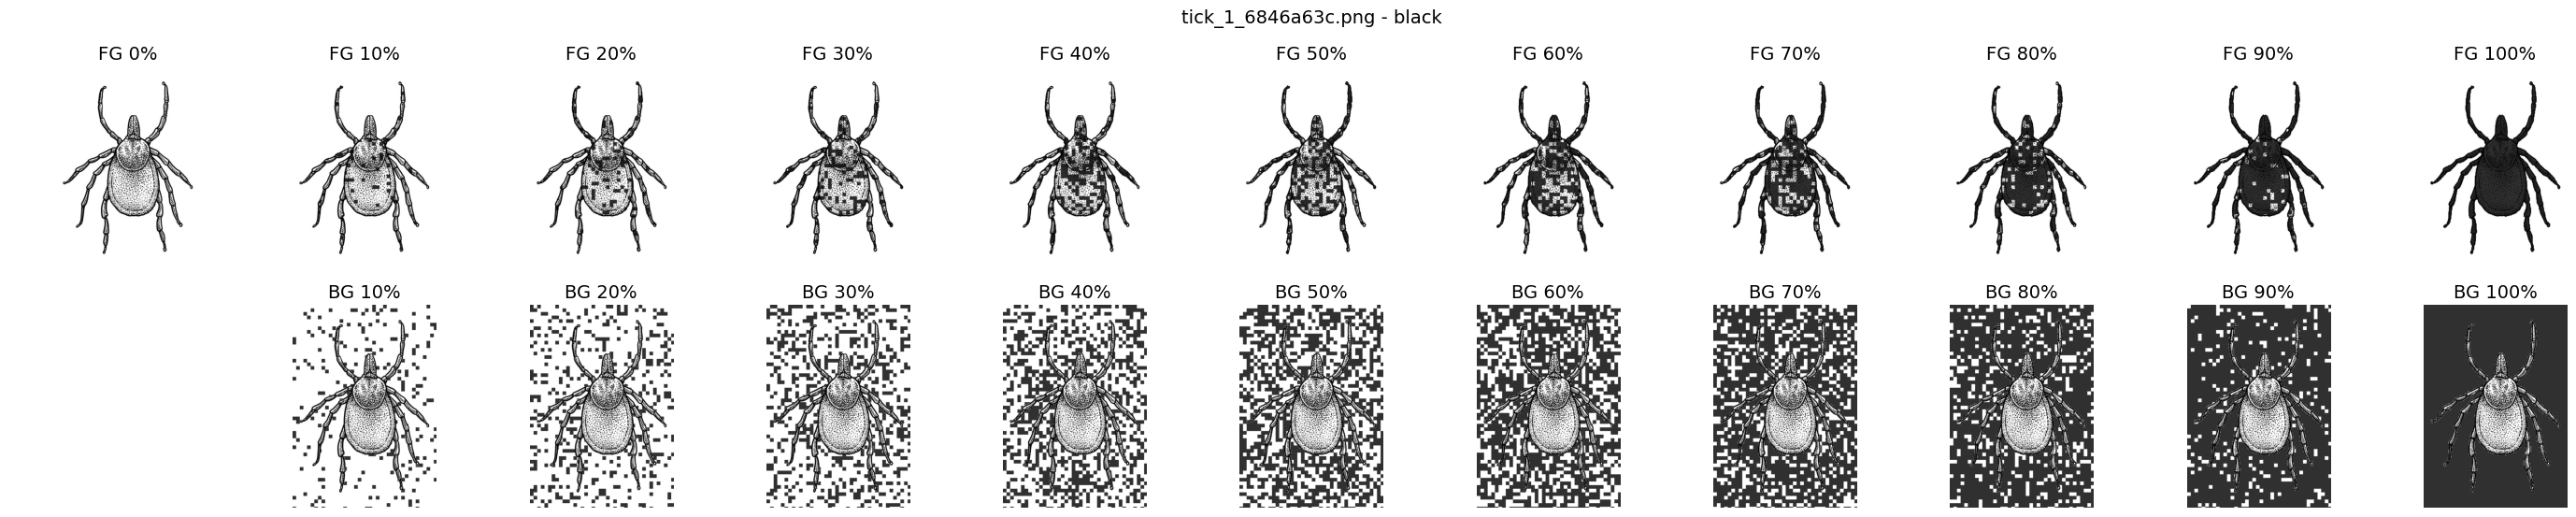

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/beets_2_c2d2422e.png


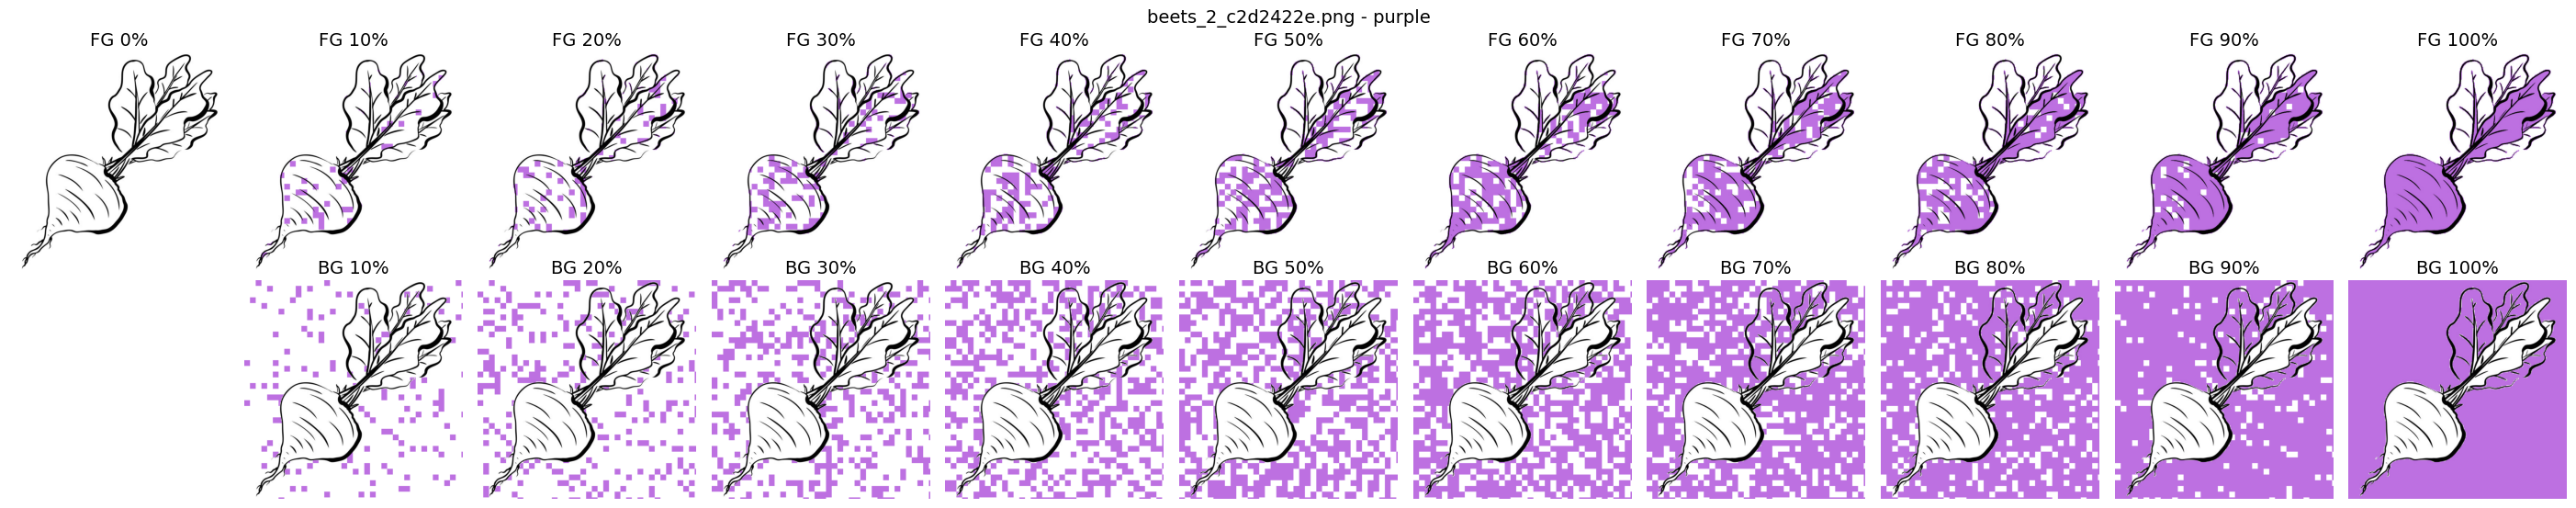

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/king_crab_3_84d9a4fa.png


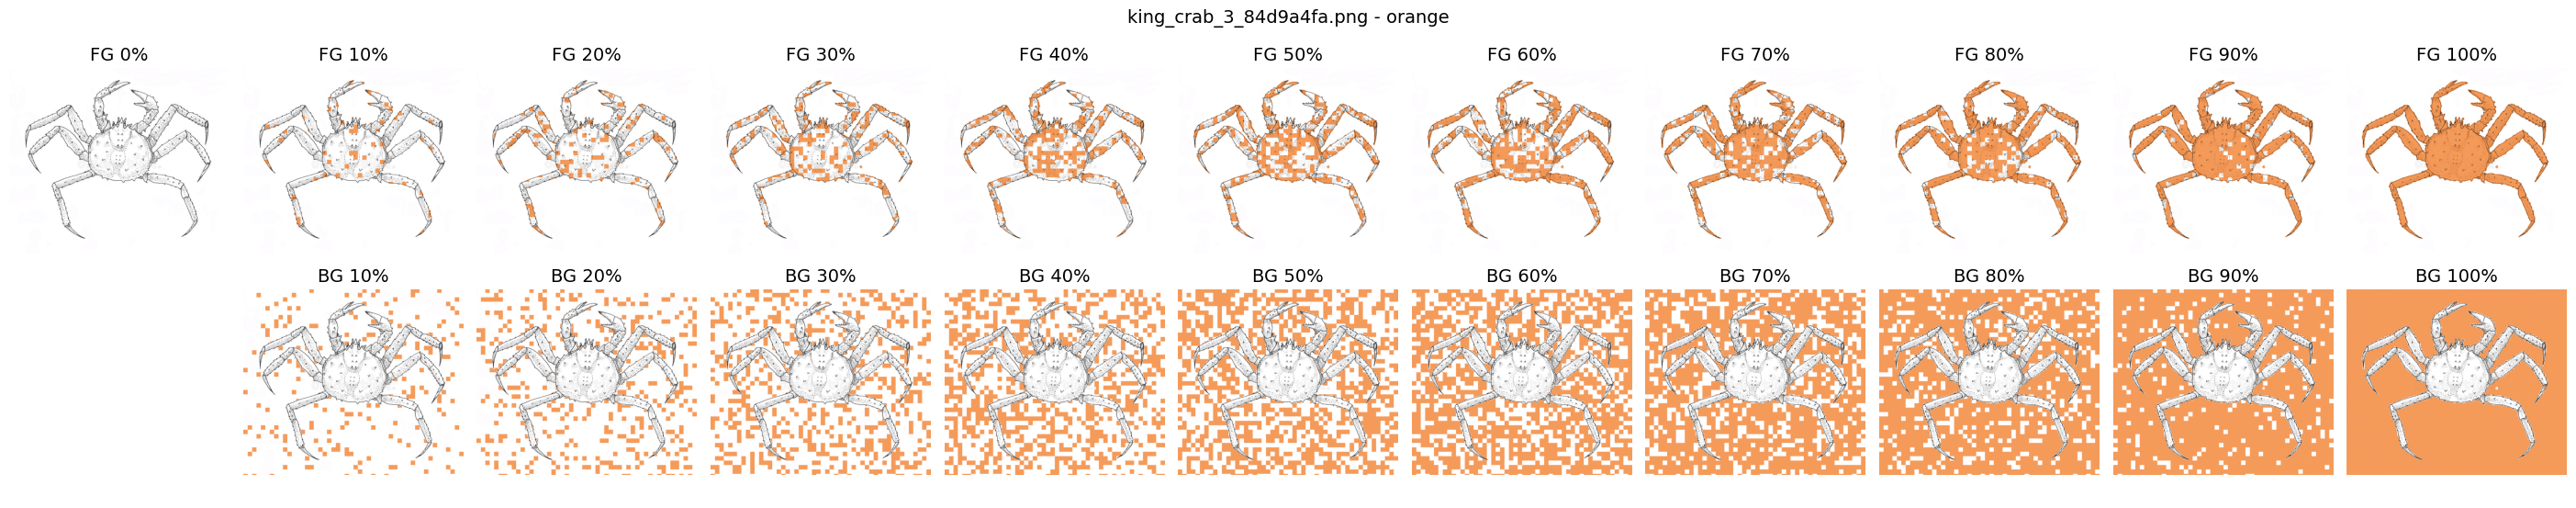

In [199]:
for idx, row in df.head().iterrows():
    target_colors = ast.literal_eval(row['correct_answer'])
    for tcol in target_colors:
        show_variants_grid(row['image_path'], tcol)

In [183]:
def variant_label(p: Path):
    name = p.name
    if "FG_" in name:
        m = re.search(r"FG_(\d{3})", name)
        return f"FG {int(m.group(1))}%" if m else "FG"
    elif "BG_" in name:
        m = re.search(r"BG_(\d{3})", name)
        return f"BG {int(m.group(1))}%" if m else "BG"
    else:
        return "white"


# --- Main evaluation ---
outline_results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row["image_path"]
    target_colors = ast.literal_eval(row["correct_answer"])
    object_name = row["object"]

    for target_color in target_colors:
        variants = collect_variants_for(image_path, target_color, out_root=color_outlines)
        if not variants:
            continue

        df_variants = pd.DataFrame({
            "image_path": [str(p) for p in variants],
            "image_variant": [variant_label(p) for p in variants],
            "object": [object_name] * len(variants),
            "correct_answer": [target_color] * len(variants)
        })

        df_most = mllm_testing(df_variants, processor, model, most="True")
        df_most = df_most.rename(columns={"predicted_color": "pred_color_most"})

        df_this = mllm_testing(df_variants, processor, model, most="False")
        df_this = df_this.rename(columns={"predicted_color": "pred_color_this"})

        merged = pd.merge(
            df_most,
            df_this,
            on=["image_path","image_variant", "object", "correct_answer"]
        )

        outline_results.append(merged)

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

df_outline = pd.concat(outline_results, ignore_index=True)
df_outline = df_outline[["object", "image_variant", "correct_answer", "pred_color_most", "pred_color_this"]]
out_path = data_folder / "outline_results.csv"
df_outline.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")

100%|██████████| 6/6 [15:04<00:00, 150.82s/it]

Saved combined outline evaluation results to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/outline_results.csv


In [207]:
df_outline[df_outline['object'] == 'king crab']

object image_variant correct_answer pred_color_most pred_color_this
84   king crab         FG 0%         orange             red           white
85   king crab        FG 10%         orange          orange          orange
86   king crab        FG 20%         orange          orange          orange
87   king crab        FG 30%         orange          orange          orange
88   king crab        FG 40%         orange          orange          orange
89   king crab        FG 50%         orange          orange          orange
90   king crab        FG 60%         orange          orange          orange
91   king crab        FG 70%         orange          orange          orange
92   king crab        FG 80%         orange          orange          orange
93   king crab        FG 90%         orange          orange          orange
94   king crab       FG 100%         orange          orange          orange
95   king crab        BG 10%         orange          orange           white
96   king crab        BG 20%         orange          orange           white
97   king crab        BG 30%         orange          orange           white
98   king crab        BG 40%         orange          orange           white
99   king crab        BG 50%         orange          orange           white
100  king crab        BG 60%         orange          orange           white
101  king crab        BG 70%         orange          orange           white
102  king crab        BG 80%         orange          orange           white
103  king crab        BG 90%         orange          orange           white
104  king crab       BG 100%         orange           white           white

In [204]:
def show_variants_grid_with_predictions(
    df_outline: pd.DataFrame,
    image_path: str,
    target_color: str,
    out_root: Path = color_outlines,
    question: str = "this",       # "this" or "most"
    thumb_w: int = 256,         
    row_h: float = 3.5
):
    """
    Display a 2-row grid of variants for a given image and color target,
    showing the model's predicted color under each image.
    """

    pred_col = "pred_color_this" if question.lower() == "this" else "pred_color_most"

    paths = collect_variants_for(image_path, target_color, out_root)
    if not paths:
        print(f"No variants found for {image_path}")
        return

    fg_paths = [p for p in paths if "FG_" in p.name]
    bg_paths = [p for p in paths if "BG_" in p.name]

    cols = len(fg_paths)
    rows = 2

    # Scale figure width 
    fig_w = cols * (thumb_w / 80)   # was /100, now larger
    fig_h = rows * row_h
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))

    # Normalize axes array
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[axes[0]], [axes[1]]]

    def get_prediction(label):
        match = df_outline[
            (df_outline["image_variant"].str.lower() == label.lower())
            & (df_outline["correct_answer"].str.lower() == target_color.lower())
        ]
        if not match.empty and pred_col in match.columns:
            return str(match.iloc[0][pred_col])
        return "—"

    def _draw_row(ax_row, paths_row, title_prefix, start_col=0):
        for c in range(cols):
            ax = ax_row[c]
            ax.axis("off")
            idx = c - start_col
            if 0 <= idx < len(paths_row):
                p = paths_row[idx]
                im = Image.open(p).convert("RGB")
                ax.imshow(im)

                m = re.search(r"(\d{3})(?=\.png$)", p.name)
                pct = int(m.group(1)) if m else ""
                variant_label = f"{title_prefix} {pct}%" if pct != "" else title_prefix
                pred = get_prediction(variant_label)

                ax.set_title(variant_label, fontsize=fontsize, pad=4)
                ax.text(
                    0.5, -0.15, pred,
                    transform=ax.transAxes,
                    ha='center', va='top',
                    fontsize=fontsize,
                    fontweight='bold'
                )

    _draw_row(axes[0], fg_paths, "FG", start_col=0)
    _draw_row(axes[1], bg_paths, "BG", start_col=1)

    fig.suptitle(
        f"{Path(image_path).name} — target: {target_color} ({question})",
        fontsize=fontsize + 4,
        fontweight="bold"
    )

    plt.subplots_adjust(top=0.85, bottom=0.1, hspace=0.4, wspace=0.05)
    plt.show()

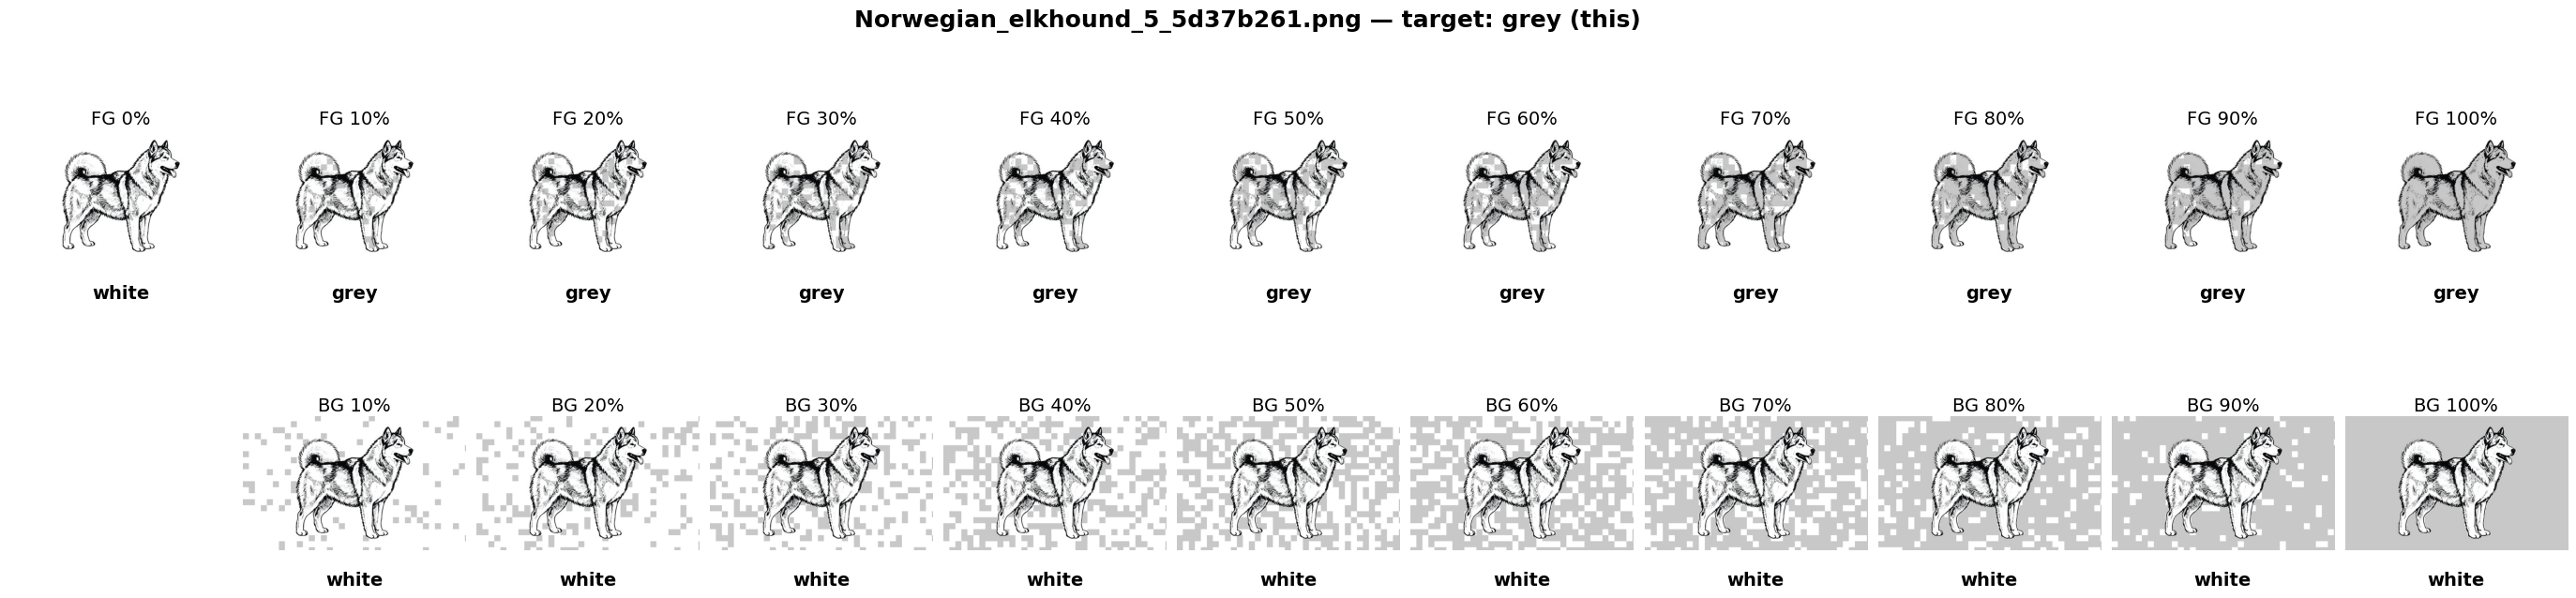

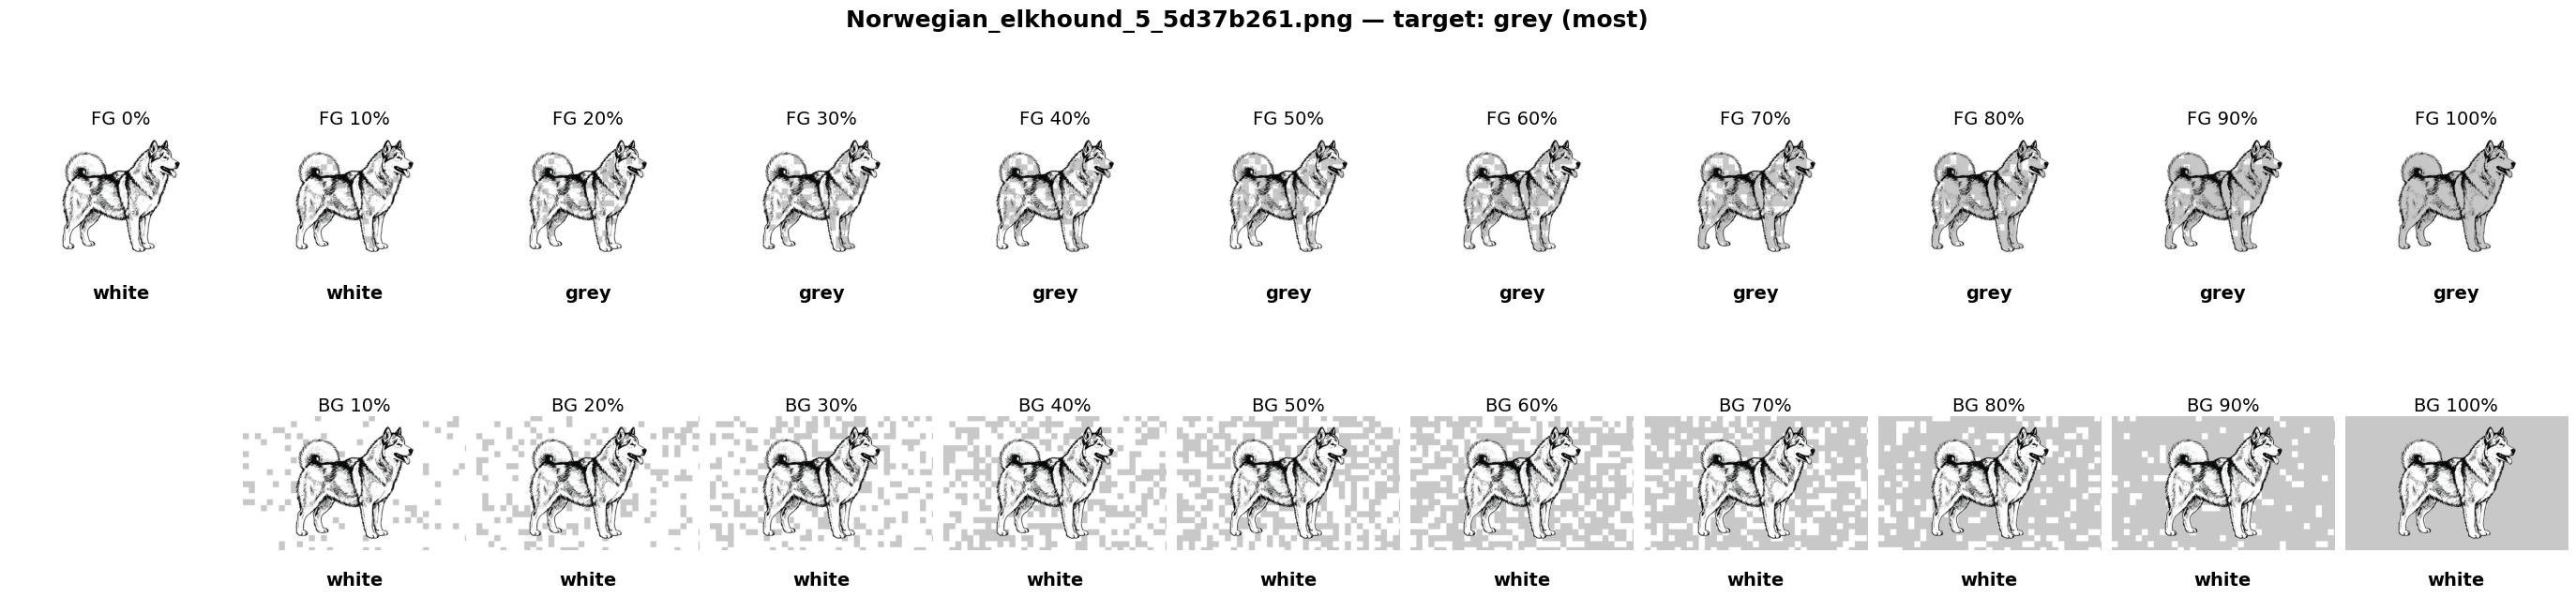

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Norwegian_elkhound_5_5d37b261.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/Norwegian_elkhound_5_5d37b261.png


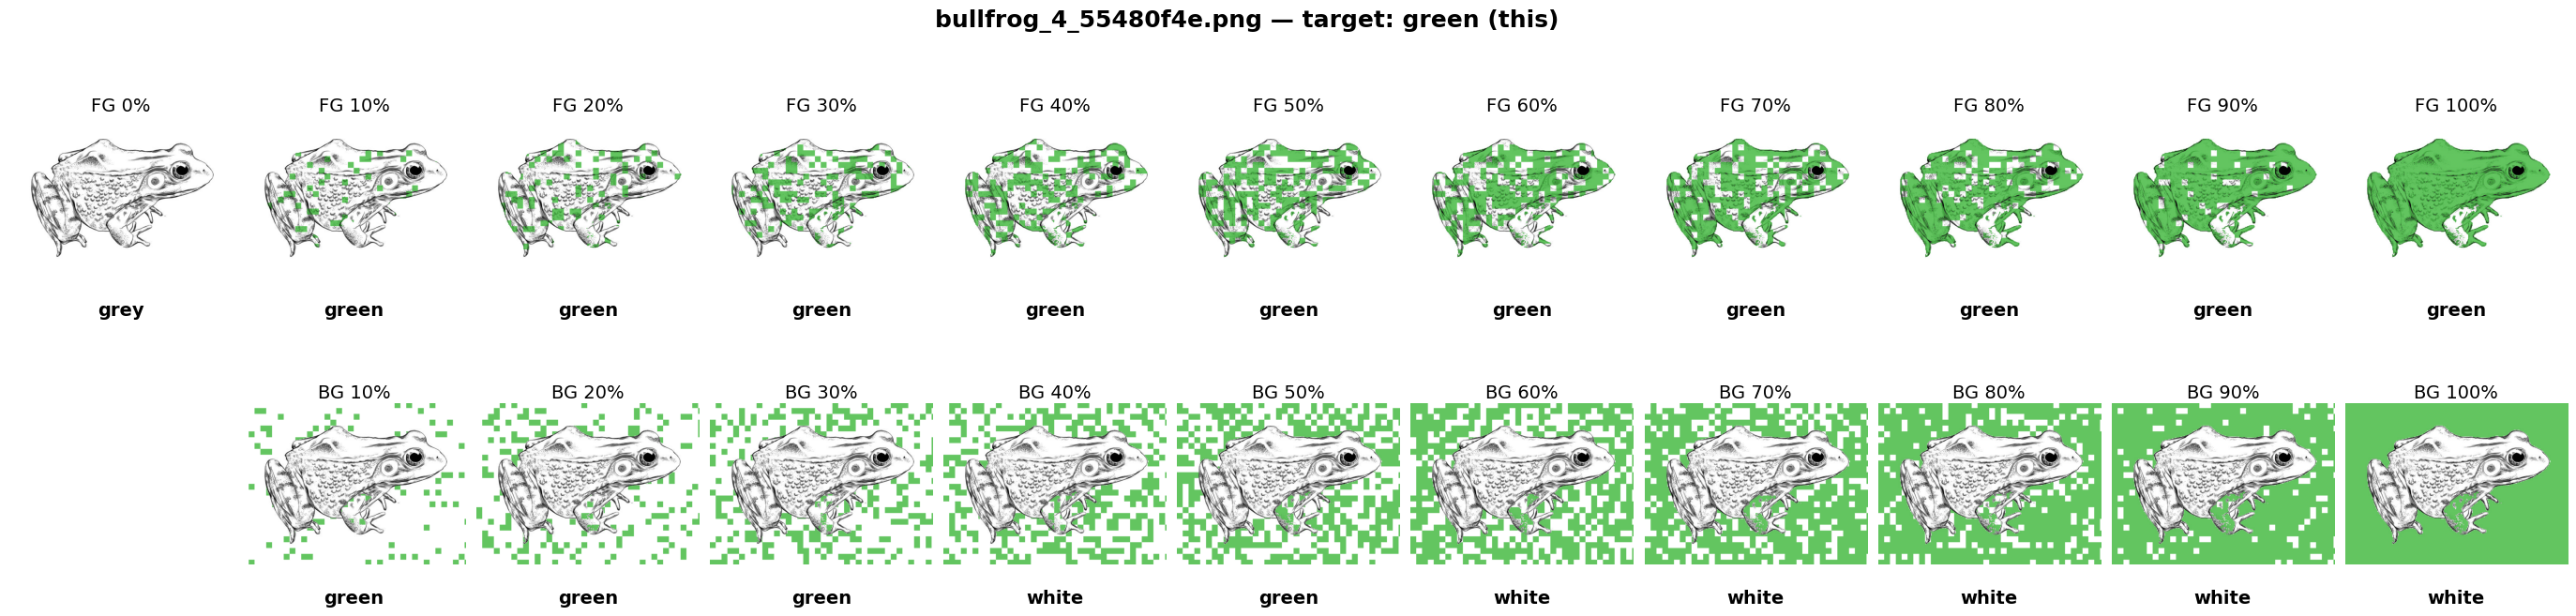

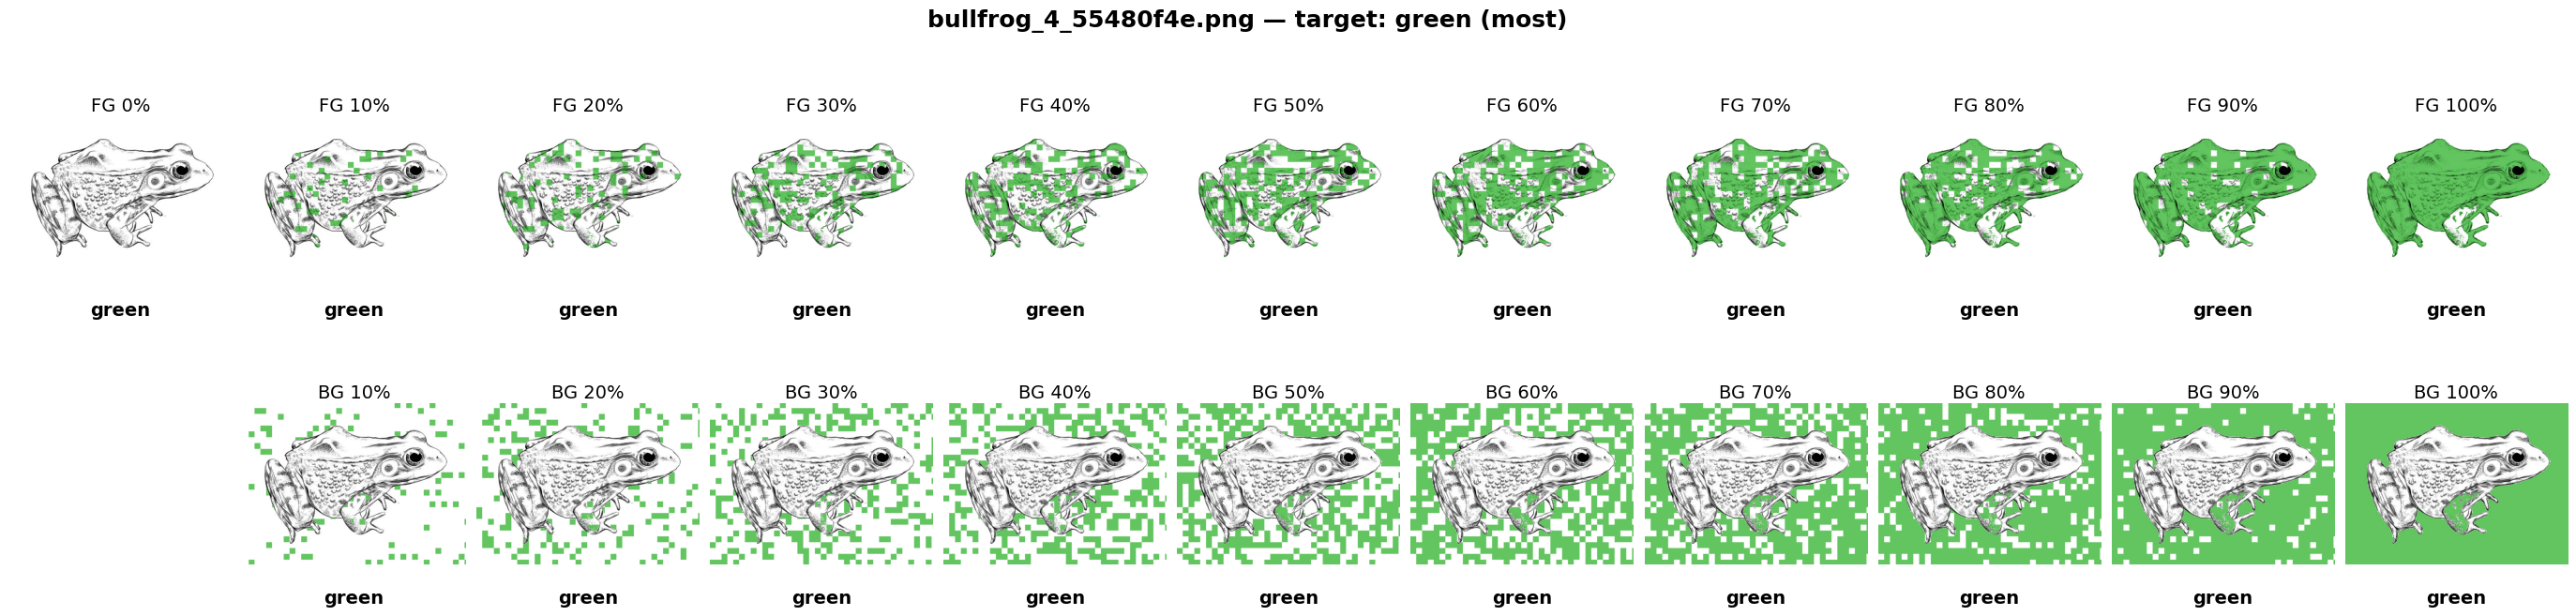

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/tick_1_6846a63c.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/tick_1_6846a63c.png


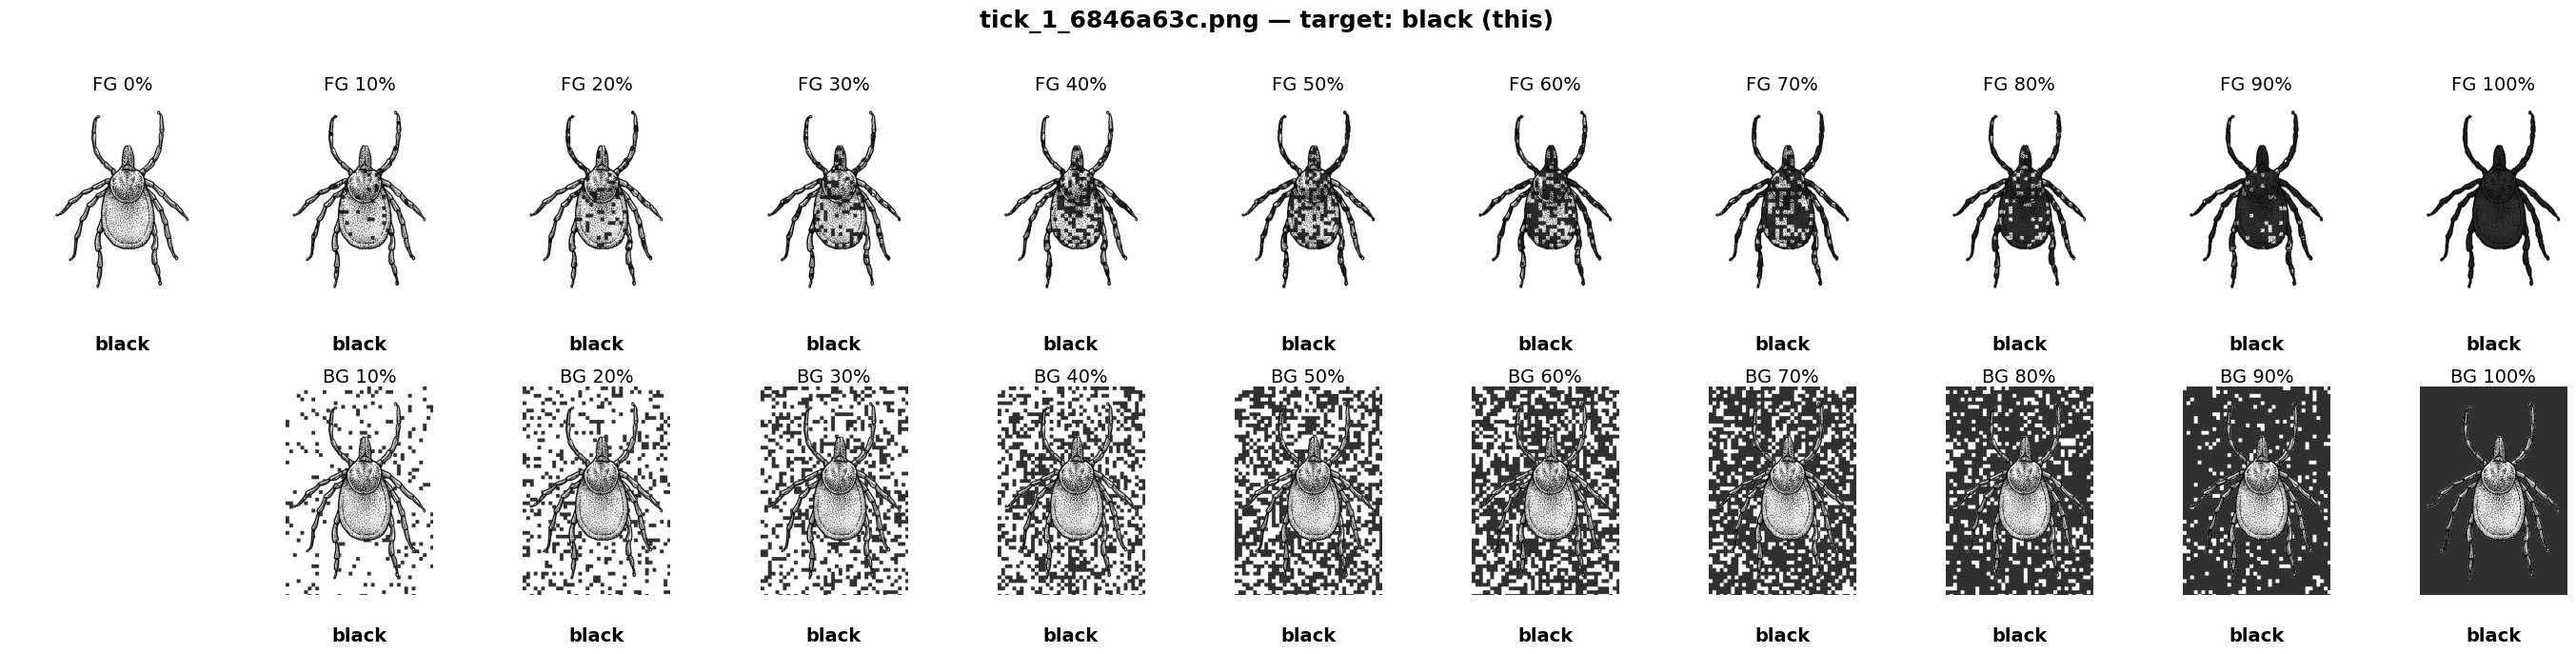

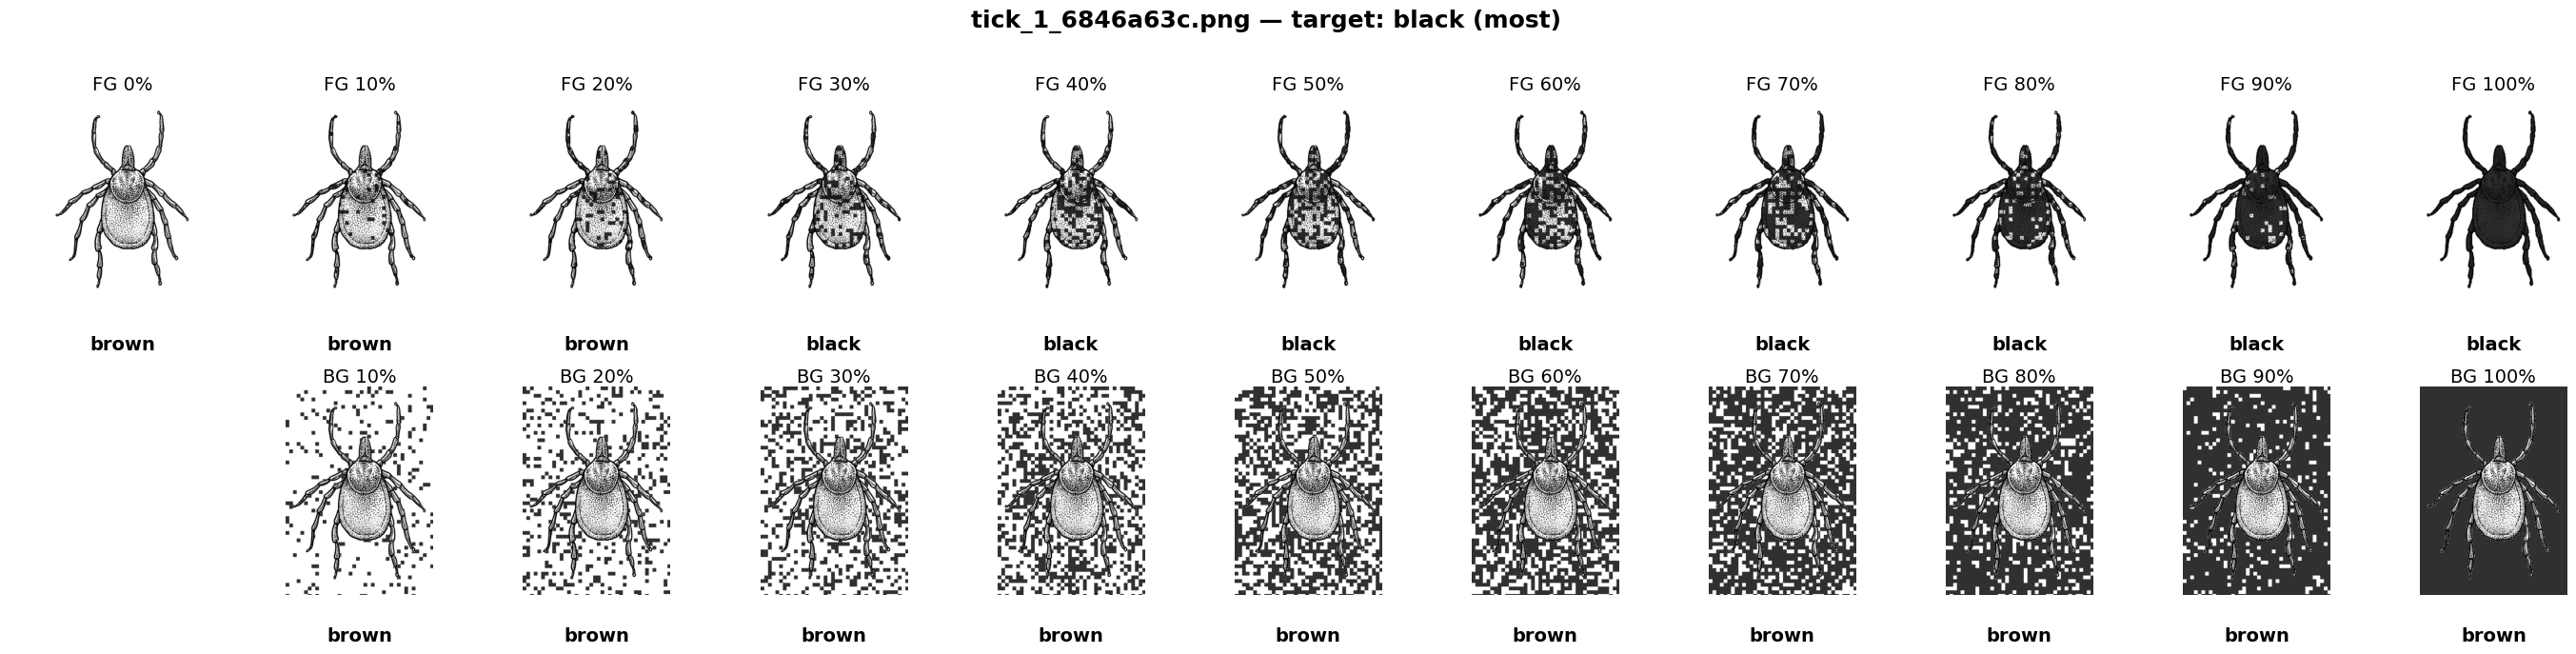

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/beets_2_c2d2422e.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/beets_2_c2d2422e.png


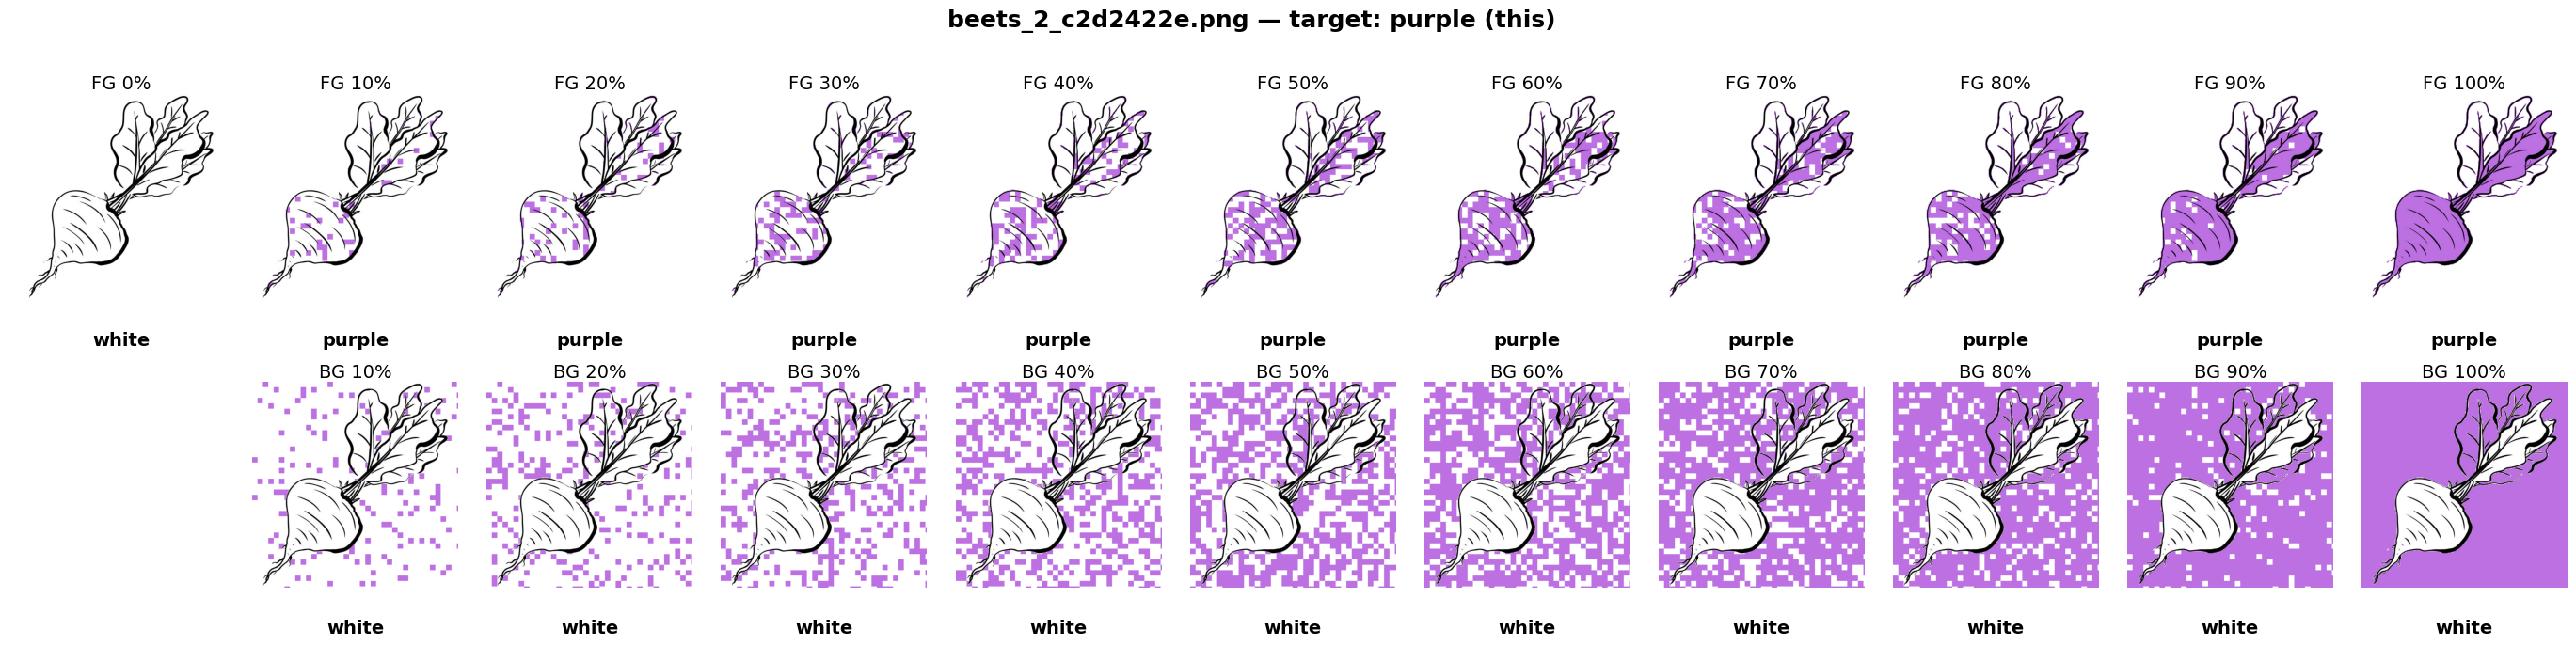

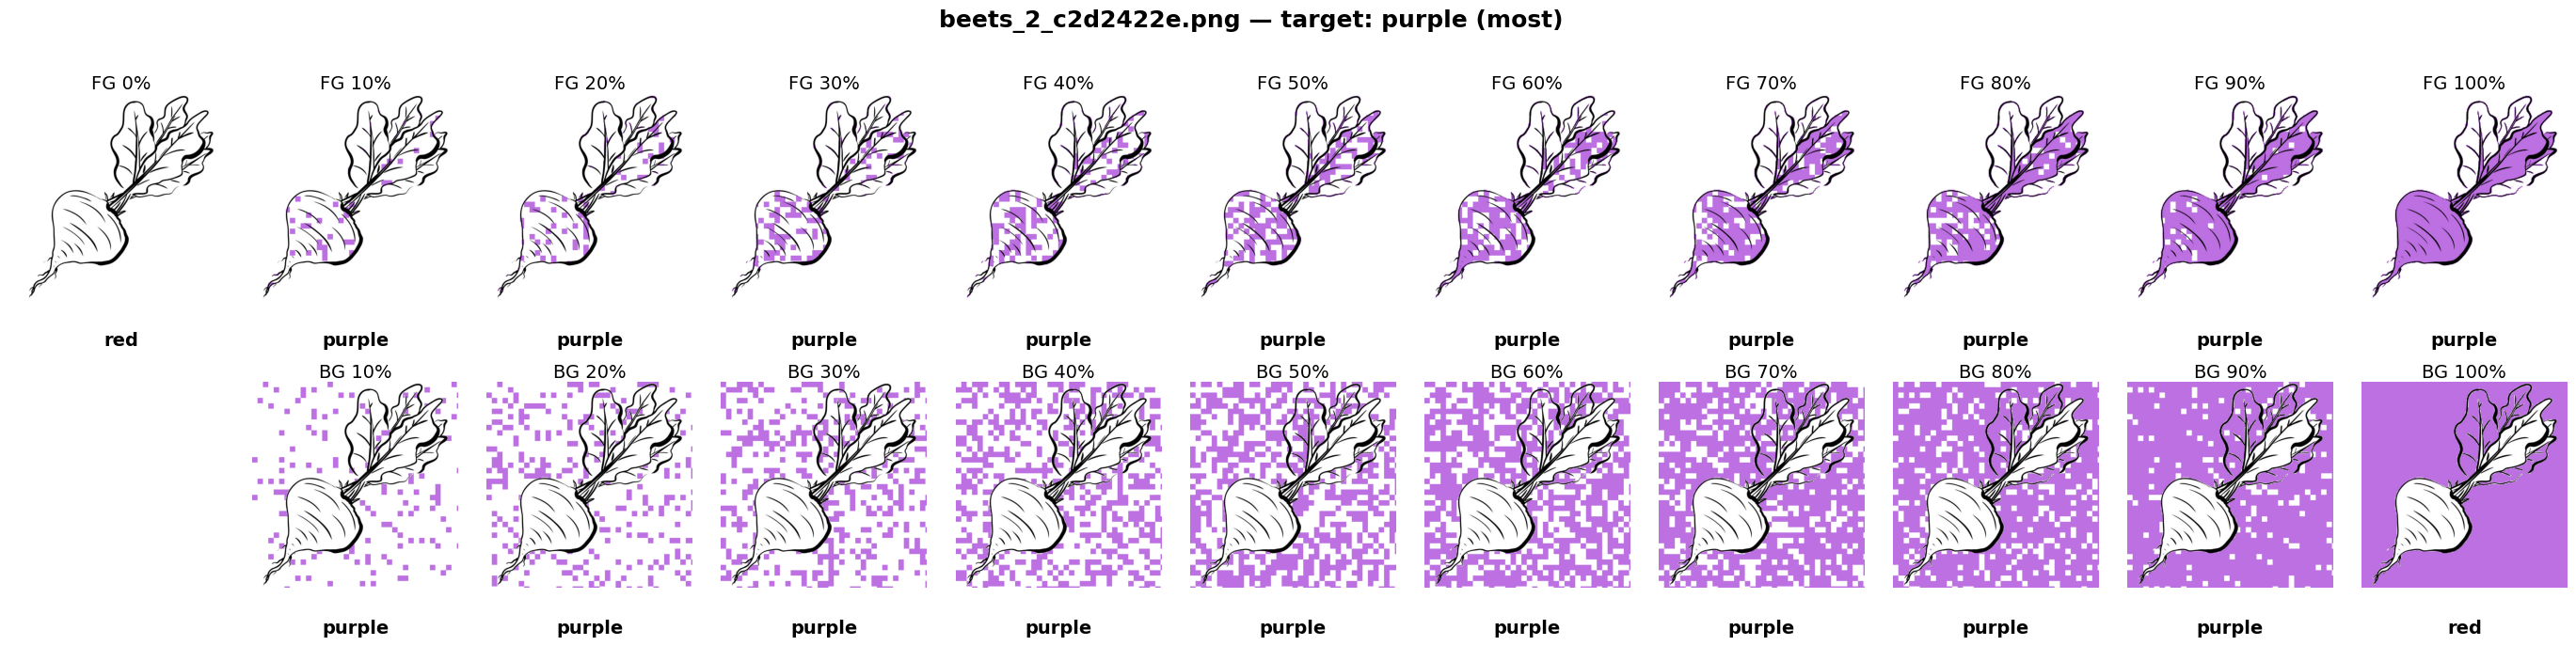

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/king_crab_3_84d9a4fa.png
No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/norm_outline_images/king_crab_3_84d9a4fa.png


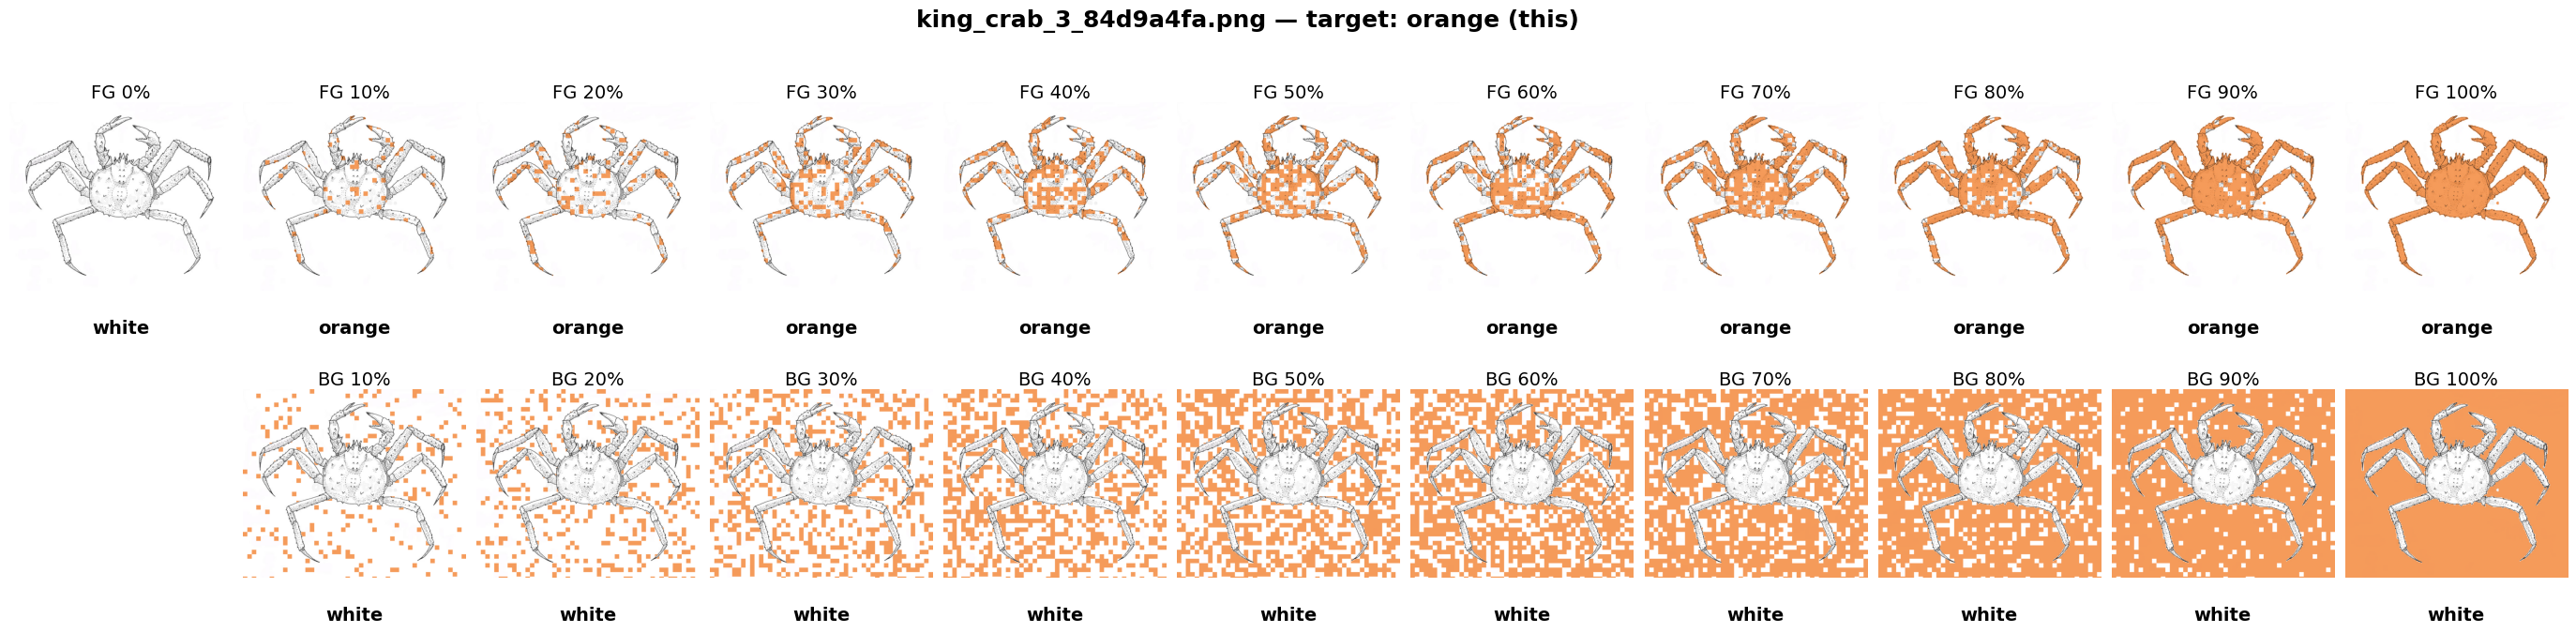

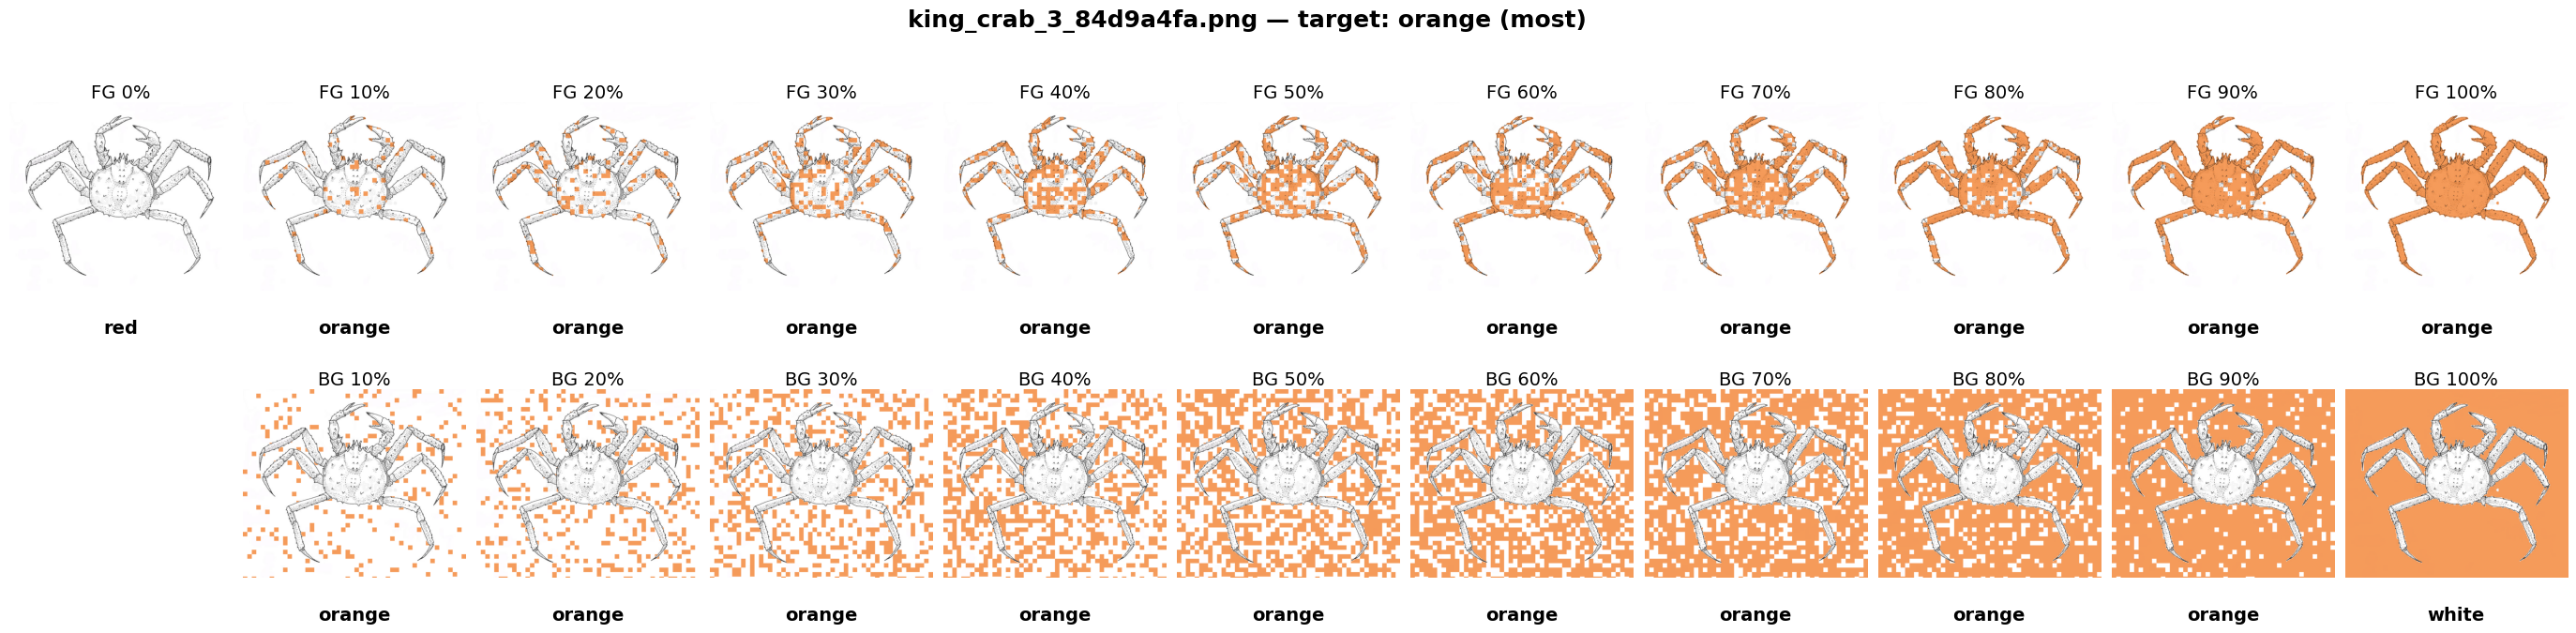

In [205]:
for idx, row in df.head().iterrows():
    target_colors = ast.literal_eval(row['correct_answer'])
    for tcol in target_colors:
        # Show predictions for both question types
        show_variants_grid_with_predictions(df_outline, row["image_path"], tcol, question="this")
        show_variants_grid_with_predictions(df_outline, row["image_path"], tcol, question="most")